# Preparation

In [1]:
#Git Repo Hammam Tugas Akhir
import csv
import regex
import datetime as dt
from datetime import timedelta
import locale
locale.setlocale(locale.LC_TIME, 'id-ID.UTF-8')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")
#from feature_engine.outlier_removers import Winsorizer

## Import dataset

In [2]:
df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2006-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_2003-2105.csv")
# df = pd.read_csv("Coret-Coret Marketing_Transaction Details (TA Hammam)_1904-2104.csv")
display(df.info())
df.to_csv("Hasil/Data_TA.csv")
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52395 entries, 0 to 52394
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   delivery_date     52395 non-null  object 
 1   delivery_status   52395 non-null  object 
 2   no_order          52395 non-null  object 
 3   Channel           52395 non-null  object 
 4   transaction_type  52395 non-null  object 
 5   ID CL             30802 non-null  float64
 6   nama_komunitas    28003 non-null  object 
 7   name              52395 non-null  object 
 8   username          52380 non-null  object 
 9   useremail         52380 non-null  object 
 10  telp              52319 non-null  object 
 11  prod_id           51655 non-null  float64
 12  produk            51655 non-null  object 
 13  harga             52395 non-null  float64
 14  qty               52395 non-null  float64
 15  subtotal          52395 non-null  float64
dtypes: float64(5), object(11)
memory usage: 

None

,delivery_date,delivery_status,no_order,Channel,transaction_type,ID CL,nama_komunitas,name,username,useremail,telp,prod_id,produk,harga,qty,subtotal
0,1 Jun 2020,delivered,54SSWRQQQ247,CL,normal,36.0,CL09 Bu agustin,CL09 Bu Agustin,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,180.0,DAGING AYAM KARKAS 700GR,25000.0,3.0,75000.0
1,1 Jun 2020,delivered,54SSWRQQQ247,CL,normal,36.0,CL09 Bu agustin,CL09 Bu Agustin,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,166.0,DAGING AYAM CEKER KG,25000.0,2.0,50000.0
2,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,237.0,GREENFIELD UHT CHOCOMALT 250ML,7000.0,2.0,14000.0
3,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,180.0,DAGING AYAM KARKAS 700GR,25000.0,3.0,75000.0
4,2 Jun 2020,delivered,54SSWSQQQ060,CL,normal,6.0,NaN,CL38 Roma Suci,Zakia Puspa Ramdhani,zakiapuspa24@gmail.com,087800014499,166.0,DAGING AYAM CEKER KG,25000.0,2.0,50000.0
5,2 Jun 2020,delivered,56SSWRQQQ053,CL,normal,12.0,CL15 Bu Mikail,CL15 Bu Mikail,Ternakfresh Indonesia,ternakmart@gmail.com,081381306699,169.0,DAGING AYAM KARKAS 1KG PARTING 12,35000.0,1.0,35000.0
6,2 Jun 2020,delivered,56SSWRQQQ053,CL,normal,12.0,CL15 Bu Mikail,CL15 Bu Mikail,Ternakfresh Indonesia,ternakmart@gmail.com,081381306699,225.0,DAGING SAPI GILING 500GR,62000.0,1.0,62000.0
7,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,210.0,DAGING SAPI BUNTUT SPECIAL KG,99000.0,1.0,99000.0
8,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,240.0,GREENFIELD UHT CHOCOMALT 1000ML,22000.0,1.0,22000.0
9,2 Jun 2020,delivered,56SSWRQQQ0X0,CL,normal,11.0,CL27 Bu Intan,CL27 Bu Intan,Ternakfresh Indonesia,ternakmart@gmail.com,0895345368597,225.0,DAGING SAPI GILING 500GR,62000.0,2.0,124000.0


In [3]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (52395, 16)
Jumlah Customer : 3641
Jumlah Transaksi : 20469


# Cleaning

In [4]:
#Clean unused atribute
df.drop(['transaction_type', 'ID CL', 'nama_komunitas', 'username', 'useremail', 'prod_id', 'harga', 'qty'],axis=1)

,delivery_date,delivery_status,no_order,Channel,name,telp,produk,subtotal
0,1 Jun 2020,delivered,54SSWRQQQ247,CL,CL09 Bu Agustin,087800014499,DAGING AYAM KARKAS 700GR,75000.0
1,1 Jun 2020,delivered,54SSWRQQQ247,CL,CL09 Bu Agustin,087800014499,DAGING AYAM CEKER KG,50000.0
2,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,GREENFIELD UHT CHOCOMALT 250ML,14000.0
3,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,DAGING AYAM KARKAS 700GR,75000.0
4,2 Jun 2020,delivered,54SSWSQQQ060,CL,CL38 Roma Suci,087800014499,DAGING AYAM CEKER KG,50000.0
...,...,...,...,...,...,...,...,...
52390,31 Mei 2021,delivered,INV21053100204ZRTX,Outlet,Nanang Arief Pambudhi,089509417907,CIMORY UHT MILK MATCHA 250ML,6500.0
52391,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,WALLS MAGNUM WHITE ALMOND 80ML,13000.0
52392,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,GLICO WINGS FROSTBITE COOKIES CREAM 60ML,5000.0
52393,31 Mei 2021,delivered,INV21053100207IHPI,Outlet,Nanang Arief Pambudhi,089509417907,WALLS CORNETTO CLASIC STRAWBERRY 110ML,5000.0


## Clean Telp

In [5]:
#Drop Null
df.dropna(inplace=True)

#standarize telp number
df['telp'] = df['telp'].str.replace('-','')
df['telp'] = df['telp'].str.replace(' ','')
df['telp'] = df['telp'].str.replace('+','')
df['telp'] = df['telp'].str.replace('08', '628', 1)
df = df[df['telp'].str.startswith('628')]

#Clean admin no hp & Invalid
df = df.drop(df[df.telp.eq('6281381306699')
                | df.telp.eq('0')].index)
df = df[~df['telp'].str.contains('1234567')]

#drop number with invalid character
df = df.drop(df[df.telp.str.contains(r'[^0-9a-zA-Z]')
                | df.telp.str.contains(r'[a-zA-Z]')].index)
                
#drop abnormal telpon length
df = df[df['telp'].str.len() > 10]
df = df[df['telp'].str.len() < 15]

## Clean Name, Channel, Product

In [6]:
#Clean penyesuaian, test, dan keperluan internal
testing = ['test', 'testing', 'COBAAA', 'tes123', 'TEXTING', 'penyesuaian', 'penyelamatan', 'stok', 'stock', 'tamu', 'b2b']
df = df[~df['name'].str.contains('|'.join(testing))]

#Clean Old B2B Customer
B2B_cust = ['hotel', 'resto', 'restoran', 'cafe', 'coffee', 'Toko', 'toko', 'Patata', 'Geprek', 'Laziza', 'ayam', 'nasi', 'sego', 'Baksoe', 'Bakso', 'Rismart', 'Nu Mart', 'Warung', 'Rice box','E-Warung', 'ewarung', 'Kedai', 'geprek', 'nelongso', 'pkk', 'pkh']
df = df[~df['name'].str.contains('|'.join(B2B_cust))] 

#Clean B2B Product
B2Bproduct = ['B2B']
df = df[~df['produk'].str.contains('|'.join(B2Bproduct))] 

#Clean Based on Channel
channel = ['CL', 'End User', 'Shopee']
df = df[df['Channel'].isin(channel)]

#clean status non delivered
df = df[df.delivery_status.eq('delivered')]

#Cleaning outlier (Paket donasi sembako dan grosir)
## need futher data based technique
donasi = ['Donasi','donasi','Pahlawan', 'Pangan', 'garda', 'sembako', 'psbb ']
df = df[~df['name'].str.contains('|'.join(donasi))]
df = df[(df['subtotal'] > 0)]

In [7]:
print("Dataset dimension : " + str(df.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df['no_order']))))

Dataset dimension : (22083, 16)
Jumlah Customer : 1296
Jumlah Transaksi : 7558


In [8]:
#parse datetime format
df_clean = df.copy()
df_clean['delivery_date'] = df_clean['delivery_date'].apply(lambda x:dt.datetime.strptime(x,'%d %b %Y'))

df_clean.to_csv("Hasil/Data_TA Clean.csv")
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22083 entries, 0 to 52306
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   delivery_date     22083 non-null  datetime64[ns]
 1   delivery_status   22083 non-null  object        
 2   no_order          22083 non-null  object        
 3   Channel           22083 non-null  object        
 4   transaction_type  22083 non-null  object        
 5   ID CL             22083 non-null  float64       
 6   nama_komunitas    22083 non-null  object        
 7   name              22083 non-null  object        
 8   username          22083 non-null  object        
 9   useremail         22083 non-null  object        
 10  telp              22083 non-null  object        
 11  prod_id           22083 non-null  float64       
 12  produk            22083 non-null  object        
 13  harga             22083 non-null  float64       
 14  qty               2208

# Generate LRFM

In [9]:
#group by invoice 
df_group = df_clean.groupby(['no_order', 'telp', 'delivery_date'], as_index = False).agg({'subtotal':'sum'})
df_group

,no_order,telp,delivery_date,subtotal
0,54SSR0QS6022,6281231631020,2020-10-28,238000.0
1,54SSR0QTWU05,628123250805,2020-10-28,180000.0
2,54SSR0QTX0Z7,6281330302020,2020-10-19,250800.0
3,54SSR0QV0512,6281234158275,2020-10-19,52000.0
4,54SSR0QV0735,6285648248736,2020-10-28,43000.0
...,...,...,...,...
7553,INV2105310006BPXSS,6287853355732,2021-05-31,313600.0
7554,INV2105310008NUL5B,62822346282614,2021-05-31,167800.0
7555,INV2105310008PJFTU,6281357188221,2021-05-31,215000.0
7556,INV2105310012501KL,6281230739779,2021-05-31,176500.0


In [10]:
#Group By Telp
#Perform mapping to LRFM
snapshot_date = df_clean['delivery_date'].max() + timedelta(days=1)
lrfm = df_group.groupby(['telp']).agg(Length=('delivery_date', lambda x: (snapshot_date - x.min()).days),
                                   Recency=('delivery_date', lambda x: (snapshot_date - x.max()).days),
                                   Frequency=('no_order', 'count'),
                                   Monetary=('subtotal', 'sum'))
lrfm.to_csv("Hasil/Data_TA LRFM.csv")
display(lrfm)
lrfm.describe()

,Length,Recency,Frequency,Monetary
telp,,,,
628111699469,66,66,1,165500.0
628112501890,361,344,5,485000.0
628113002154,361,103,3,612600.0
628113020777,202,4,3,575000.0
62811304876,329,27,16,897300.0
...,...,...,...,...
628993360579,314,280,2,955000.0
628993464570,337,293,2,90000.0
628993883705,152,57,2,294100.0


,Length,Recency,Frequency,Monetary
count,1296.000000,1296.000000,1296.00000,1.296000e+03
mean,164.280093,107.672840,5.83179,1.152348e+06
std,108.944892,96.505799,21.22047,4.333555e+06
min,2.000000,1.000000,1.00000,1.890000e+04
25%,77.000000,34.000000,1.00000,1.520000e+05
50%,135.000000,76.500000,2.00000,2.700000e+05
75%,257.000000,152.000000,4.00000,6.583440e+05
max,365.000000,364.000000,522.00000,6.657081e+07


In [11]:
#Check Outlier on Frequency
# display(sns.boxplot(lrfm['Frequency']))

# #delete outlier
# lrfm = lrfm[~(lrfm['Frequency'] > 57)]
# sns.boxplot(x=lrfm['Frequency'])

In [12]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column], kde=False)
    
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

def norm_minmax(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 1.1345987300500122, : SkewtestResult(statistic=13.693803718844693, pvalue=1.1056633781363874e-42)
Frequency's: Skew: 14.690536673841917, : SkewtestResult(statistic=43.521629075089805, pvalue=0.0)
Monetary's: Skew: 9.772043517284278, : SkewtestResult(statistic=38.57094609139967, pvalue=0.0)


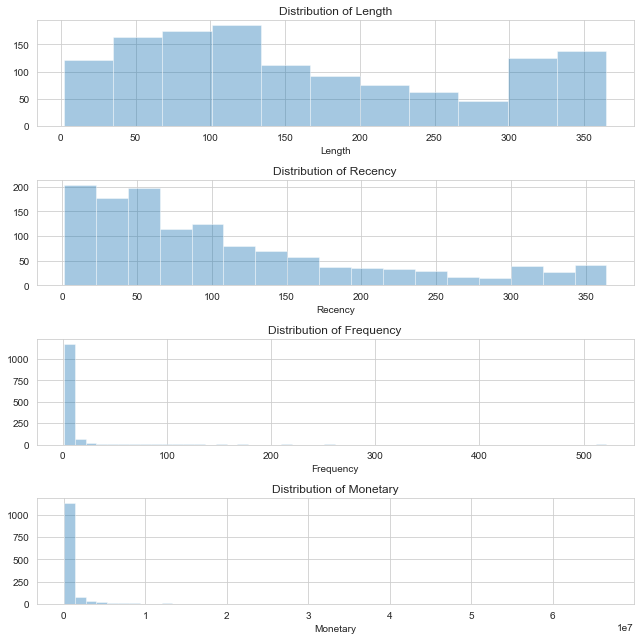

In [13]:
# Plot all 4 graphs to check skewness
plt.figure(figsize=(9, 9))

plt.subplot(4, 1, 1)
check_skew(lrfm,'Length')

plt.subplot(4, 1, 2)
check_skew(lrfm,'Recency')

plt.subplot(4, 1, 3)
check_skew(lrfm,'Frequency')

plt.subplot(4, 1, 4)
check_skew(lrfm,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/before_transform.png', format='png', dpi=1000)

In [14]:
#Frequency dan monetary skewnya ndak masuk akal

## Transformation & Normalization

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 0.36681335863818454, : SkewtestResult(statistic=5.256882607546363, pvalue=1.4651777192440396e-07)
Frequency's: Skew: 1.9560846598864, : SkewtestResult(statistic=19.474811033117195, pvalue=1.7958576086075768e-84)
Monetary's: Skew: 0.8902792272064285, : SkewtestResult(statistic=11.412303075622109, pvalue=3.6298912702912806e-30)


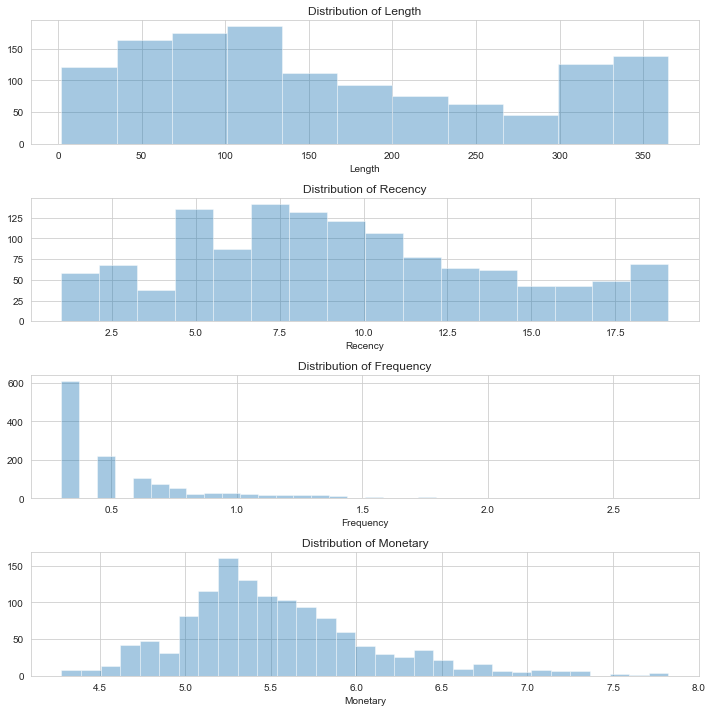

In [15]:
lrfm_trans = lrfm.copy()

lrfm_trans['Recency'] = np.sqrt(lrfm_trans['Recency'])
lrfm_trans['Frequency'] = np.log10(lrfm_trans['Frequency']+1)
lrfm_trans['Monetary'] = np.log10(lrfm_trans['Monetary']+1)

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/after_transform-1.png', format='png', dpi=1000)

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 0.36681335863818454, : SkewtestResult(statistic=5.256882607546363, pvalue=1.4651777192440396e-07)
Frequency's: Skew: 1.3015004672458956, : SkewtestResult(statistic=15.076376955497514, pvalue=2.3163579496605277e-51)
Monetary's: Skew: 0.7103691081370308, : SkewtestResult(statistic=9.504341881962509, pvalue=2.0131691995943413e-21)


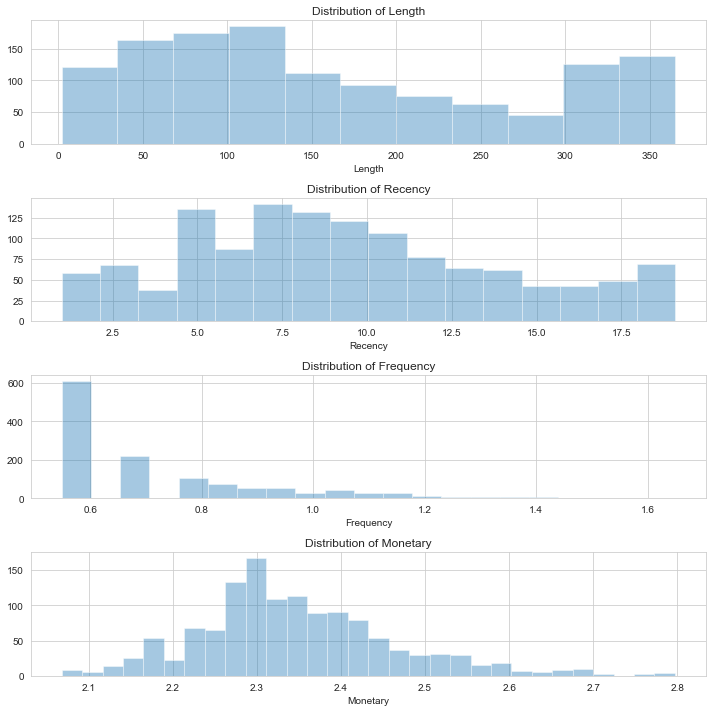

In [16]:
lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])
lrfm_trans['Monetary'] = np.sqrt(lrfm_trans['Monetary'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/after_transform-2.png', format='png', dpi=1000)

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 0.36681335863818454, : SkewtestResult(statistic=5.256882607546363, pvalue=1.4651777192440396e-07)
Frequency's: Skew: 1.0471724433355378, : SkewtestResult(statistic=12.915075531650865, pvalue=3.7008073040811544e-38)
Monetary's: Skew: 0.7103691081370308, : SkewtestResult(statistic=9.504341881962509, pvalue=2.0131691995943413e-21)


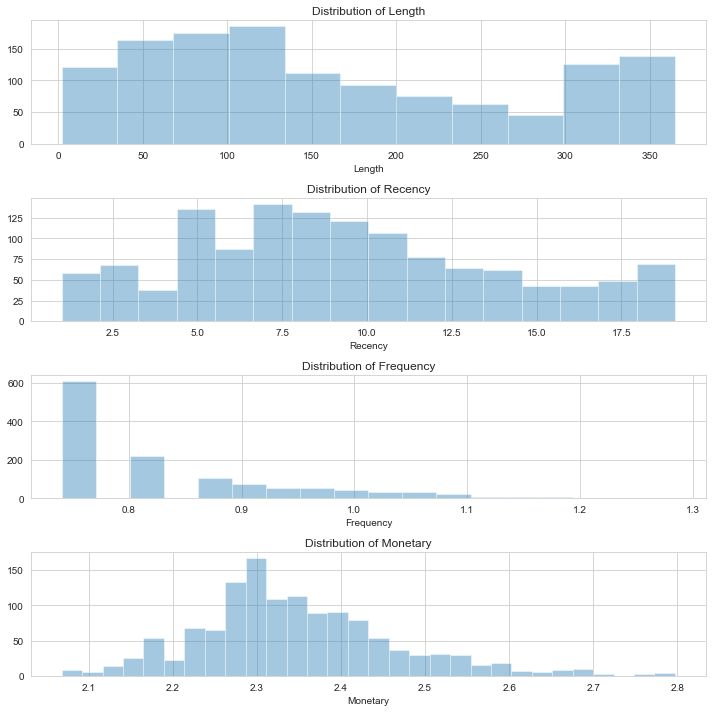

In [17]:
lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/after_transform-3.png', format='png', dpi=1000)

Length's: Skew: 0.42393719034736754, : SkewtestResult(statistic=6.017996054132643, pvalue=1.7658949748527417e-09)
Recency's: Skew: 0.36681335863818454, : SkewtestResult(statistic=5.256882607546363, pvalue=1.4651777192440396e-07)
Frequency's: Skew: 0.9359316636748146, : SkewtestResult(statistic=11.864262867744463, pvalue=1.814939030909096e-32)
Monetary's: Skew: 0.7103691081370308, : SkewtestResult(statistic=9.504341881962509, pvalue=2.0131691995943413e-21)


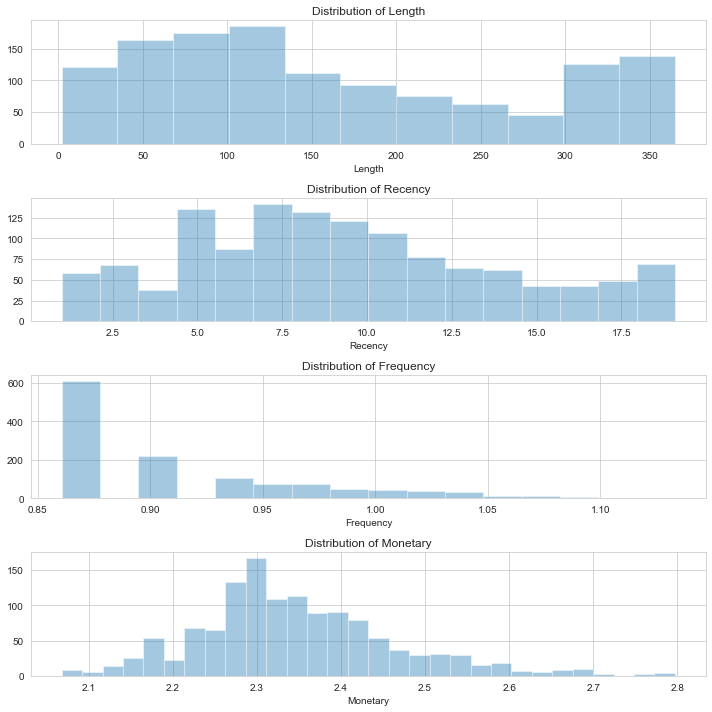

In [18]:
lrfm_trans['Frequency'] = np.sqrt(lrfm_trans['Frequency'])

plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
check_skew(lrfm_trans,'Length')
plt.subplot(4, 1, 2)
check_skew(lrfm_trans,'Recency')
plt.subplot(4, 1, 3)
check_skew(lrfm_trans,'Frequency')
plt.subplot(4, 1, 4)
check_skew(lrfm_trans,'Monetary')

plt.tight_layout()
plt.savefig('Grafik/after_transform-4.png', format='png', dpi=1000)

In [19]:
#Min-Max Normalization
norm_lrfm = norm_minmax(lrfm_trans)

#Mengubah nilai Recency menggunakan 1-R karena merupakan kebalikan dari variabel lain
#R asli jika semakin kecil akan semakin bagus
norm_lrfm['Recency'] = 1-norm_lrfm['Recency']

norm_lrfm.describe()

,Length,Recency,Frequency,Monetary
count,1296.000000,1296.000000,1296.000000,1296.000000
mean,0.447053,0.541158,0.194882,0.383230
std,0.300124,0.255201,0.225194,0.160421
min,0.000000,0.000000,0.000000,0.000000
25%,0.206612,0.373363,0.000000,0.285853
50%,0.366391,0.571521,0.187155,0.360145
75%,0.702479,0.732783,0.350700,0.472096
max,1.000000,1.000000,1.000000,1.000000


# K-Means Clustering

In [20]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator

## Find K Optimum

Elbow at K = 3


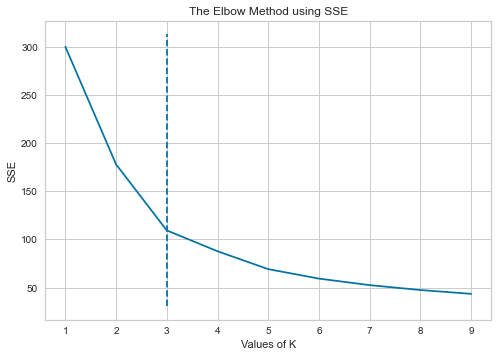

Elbow at K = 3


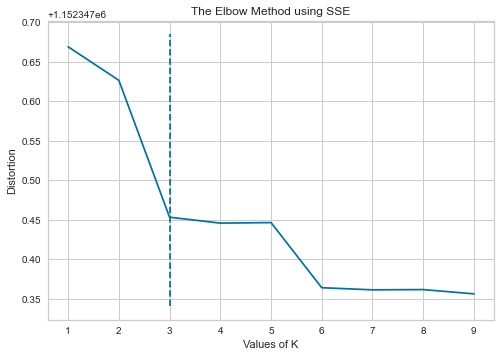

In [21]:
# Elbow method Viz
K_elbow = range(1,10)
inertias = []
distortions = []

for k in K_elbow: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=123)
    kmeanModel.fit(norm_lrfm)     

    #Elbow Method metrics
    inertias.append(kmeanModel.inertia_) 
    distortions.append(sum(np.min(cdist(lrfm, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / norm_lrfm.shape[0])     

kn = KneeLocator(K_elbow, inertias, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K_elbow, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('SSE') 
plt.title('The Elbow Method using SSE') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using Inertia.png', format='png', dpi=1000)
plt.show() 

kn = KneeLocator(K_elbow, distortions, curve='convex', direction='decreasing')
print("Elbow at K =", kn.knee)

plt.plot(K_elbow, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using SSE') 
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Elbow Method using distortion.png', format='png', dpi=1000)
plt.show() 

In [22]:
K = range(2,10)
# fig, ax = plt.subplots(4, 2, figsize=(15,15))

# Silhouette Method metrics
euclidean = []
ch_index = []
db_index = []
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=123)
    kmeanModel.fit(norm_lrfm)     
    
    # Silhouette Method metrics
    euclidean.append(silhouette_score(norm_lrfm, kmeanModel.labels_, metric='euclidean'))

    # Silhouette also
    # q, mod = divmod(k, 2)
    # visualizer = SilhouetteVisualizer(kmeanModel, colors='yellowbrick', ax=ax[q-1][mod])
    # visualizer.fit(norm_lrfm)

    # C-H Index
    ch_index.append(calinski_harabasz_score(norm_lrfm,kmeanModel.labels_))

    # DB Index
    db_index.append(davies_bouldin_score(norm_lrfm,kmeanModel.labels_))


Highest Euclidean Value = 0.433208132703208 at K=3


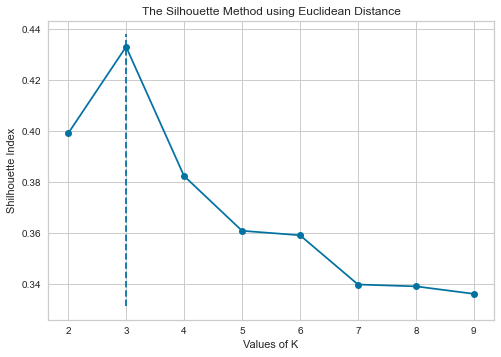

In [23]:
ymax = max(euclidean)
xpos = euclidean.index(ymax)
xmax = K[xpos]

print("Highest Euclidean Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, euclidean, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('Shilhouette Index') 
plt.title('The Silhouette Method using Euclidean Distance') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/Silhouette Method using Euclidean Distance.png', format='png', dpi=1000)
plt.show() 

In [24]:
euclidean

[0.3991597713597566,
 0.433208132703208,
 0.38245859922741365,
 0.36094300914828076,
 0.3592024081112948,
 0.3398567739665069,
 0.33912450252570775,
 0.336184910232337]

Highest CH-Index Value = 1126.033482342435 at K=3


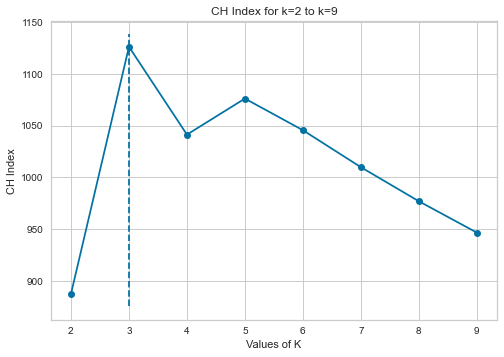

In [25]:
# CH Index Viz
ymax = max(ch_index)
xpos = ch_index.index(ymax)
xmax = K[xpos]

print("Highest CH-Index Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, ch_index, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('CH Index') 
plt.title('CH Index for k=2 to k=9') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.savefig('Grafik/CH Index.png', format='png', dpi=1000)
plt.show() 

Lowest DB Index Value = 1126.033482342435 at K=3


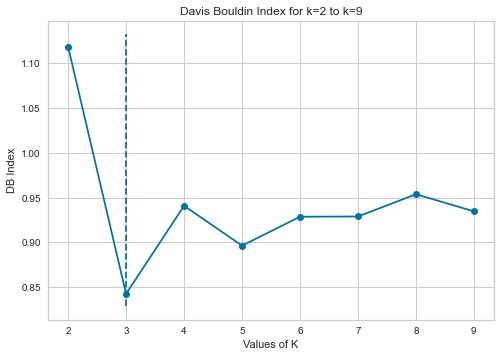

In [26]:
# DB Index Viz
ymin = min(db_index)
xpos = db_index.index(ymin)
xmax = K[xpos]

print("Lowest DB Index Value = %s at K=%s" % (ymax, xmax,))
plt.plot(K, db_index, 'bo-') 
plt.xlabel('Values of K') 
plt.ylabel('DB Index') 
plt.title('Davis Bouldin Index for k=2 to k=9') 
plt.vlines(xmax, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show() 

## Clustering!!

In [27]:
#Set K Value
K_fix = 3

In [28]:
def kmeans(normalised_df_lrfm, clusters_number, original_df_lrfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 123)
    kmeans.fit(normalised_df_lrfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_lrfm.assign(Cluster = cluster_labels)
    df_new['Cluster'] += 1
    return df_new

def flatened2d(df_new):
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=df_new['Cluster'], style=df_new['Cluster'], palette="Set1")

def snake_plot(normalised_df_lrfm, df_lrfm_kmeans, df_lrfm_original):

    normalised_df_lrfm = pd.DataFrame(normalised_df_lrfm, 
                                       index=df_lrfm_original.index, 
                                       columns=df_lrfm_original.columns)
    normalised_df_lrfm['Cluster'] = df_lrfm_kmeans['Cluster']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_lrfm.reset_index(), 
                        id_vars=['telp', 'Cluster'],
                        value_vars=['Length', 'Recency', 'Frequency', 'Monetary'], 
                        var_name='Metric', 
                        value_name='Value')

    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

def threeD_plot(df_merge):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(16, 9))
    ax = fig.gca(projection='3d')
    ax.set_title("3D Plot of K = %s" % (K_fix))
    
    x = np.array(df_merge['Recency_norm'])
    y = np.array(df_merge['Frequency_norm'])
    z = np.array(df_merge['Monetary_norm'])
    ax.scatter(x,y,z, s=(df_merge['Length_norm']*40), marker="s", c=df_merge["Cluster"], cmap="rainbow")
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('Monetary')

    return


In [29]:
#CLlustering K-Means
df_cluster_fix = kmeans(norm_lrfm, K_fix, lrfm)

df_lrfm_all = pd.merge(df_cluster_fix, norm_lrfm, on='telp', suffixes=('_real', '_norm'))
df_lrfm_all.to_csv("Hasil/Data_TA Clustered_LRFM.csv")
df_lrfm_all

,Length_real,Recency_real,Frequency_real,Monetary_real,Cluster,Length_norm,Recency_norm,Frequency_norm,Monetary_norm
telp,,,,,,,,,
628111699469,66,66,1,165500.0,2,0.176309,0.605945,0.000000,0.296967
628112501890,361,344,5,485000.0,3,0.988981,0.029402,0.398087,0.434146
628113002154,361,103,3,612600.0,3,0.988981,0.493943,0.285844,0.463192
628113020777,202,4,3,575000.0,1,0.550964,0.944687,0.285844,0.455340
62811304876,329,27,16,897300.0,1,0.900826,0.767896,0.607727,0.510115
...,...,...,...,...,...,...,...,...,...
628993360579,314,280,2,955000.0,3,0.859504,0.129742,0.187155,0.517715
628993464570,337,293,2,90000.0,3,0.922865,0.108500,0.187155,0.216512
628993883705,152,57,2,294100.0,2,0.413223,0.637706,0.187155,0.371053


In [30]:
df_lrfm_all.iloc[:,[5,6,7,8]]

,Length_norm,Recency_norm,Frequency_norm,Monetary_norm
telp,,,,
628111699469,0.176309,0.605945,0.000000,0.296967
628112501890,0.988981,0.029402,0.398087,0.434146
628113002154,0.988981,0.493943,0.285844,0.463192
628113020777,0.550964,0.944687,0.285844,0.455340
62811304876,0.900826,0.767896,0.607727,0.510115
...,...,...,...,...
628993360579,0.859504,0.129742,0.187155,0.517715
628993464570,0.922865,0.108500,0.187155,0.216512
628993883705,0.413223,0.637706,0.187155,0.371053


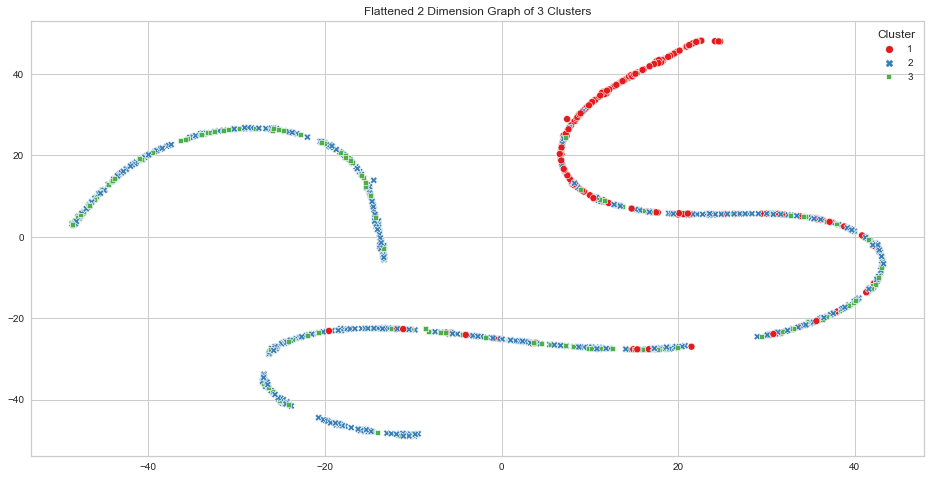

In [31]:
#Flattened Scatter Plot
plt.figure(figsize=(16, 8))
plt.title('Flattened 2 Dimension Graph of %s Clusters' % (K_fix))
flatened2d(df_cluster_fix)
plt.savefig('Grafik/Flattened 2 Dimension Graph.png', format='png', dpi=300)

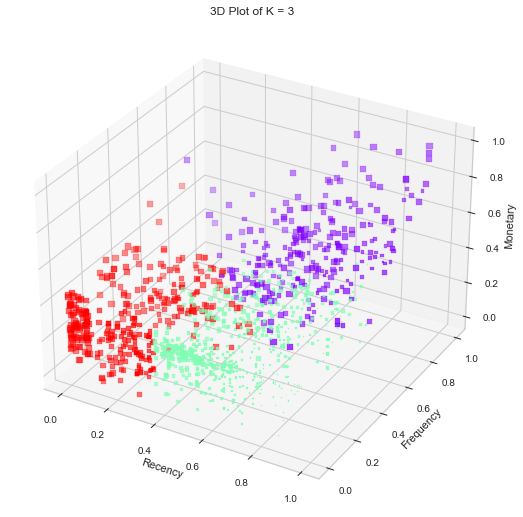

In [32]:
#3D Plot
threeD_plot(df_lrfm_all)
plt.savefig('Grafik/Cluster_is_3-3dplot.png', format='png', dpi=300)

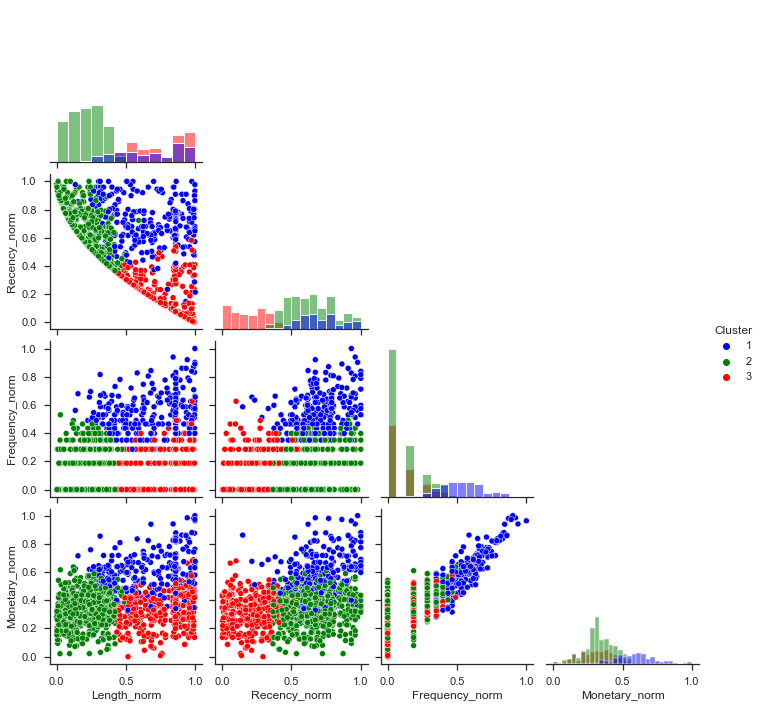

In [33]:
#matrix scatterplot
sns.set_theme(style="ticks")
scat = df_lrfm_all.iloc[:,-5:]
sns.pairplot(scat, hue='Cluster', palette= {1: "blue", 2: "green", 3: "red"}, diag_kind="hist", corner=True)
plt.savefig('Grafik/Cluster_is_3-3dplot.png', format='png', dpi=300)

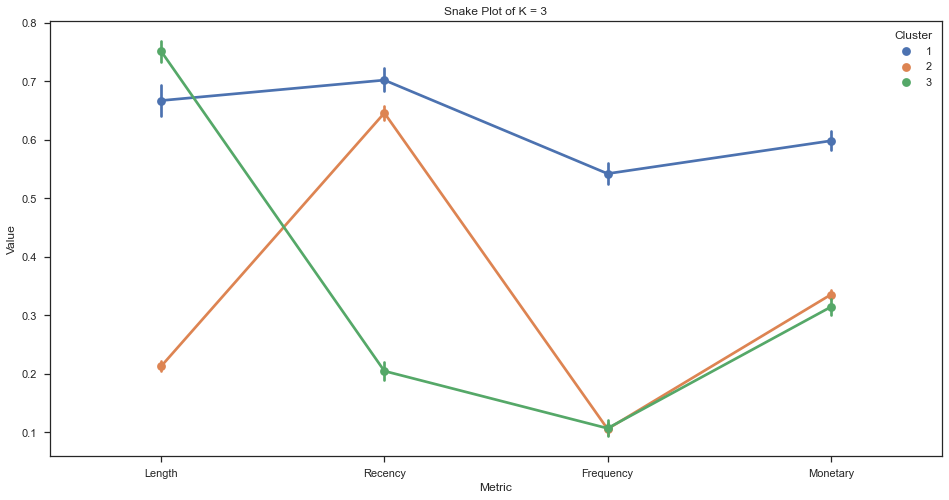

In [34]:
#Snake Plot
plt.figure(figsize=(16, 8))
plt.title("Snake Plot of K = %s" % (K_fix))
snake_plot(norm_lrfm, df_cluster_fix, lrfm)
plt.savefig('Grafik/Cluster_is_3-snakeplot.png', format='png', dpi=300)

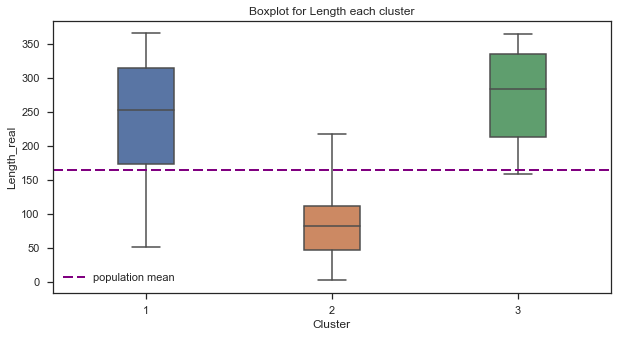

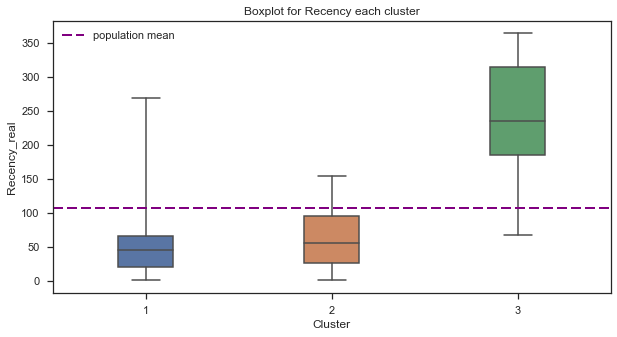

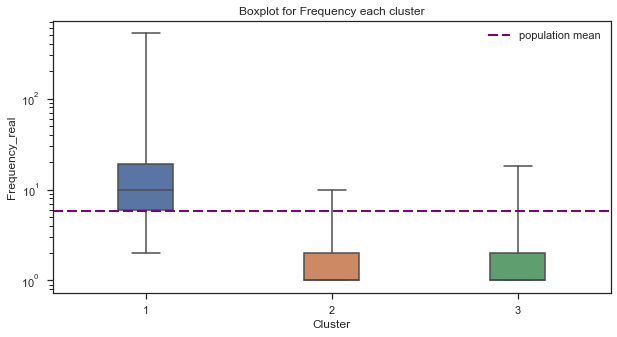

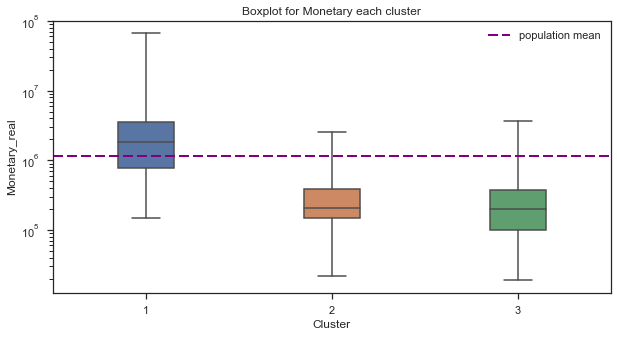

In [35]:
#BoxPlot for Real Data
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Length_real", data=df_lrfm_all, width=0.3, whis=10)
L_mean = df_lrfm_all["Length_real"].mean()
plt.plot([-0.5, 2.5], [L_mean, L_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.title('Boxplot for Length each cluster') 
plt.legend()
plt.savefig('Grafik/boxplot L.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Recency_real", data=df_lrfm_all, width=0.3, whis=10)
R_mean = df_lrfm_all["Recency_real"].mean()
plt.plot([-0.5, 2.5], [R_mean, R_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.title('Boxplot for Recency each cluster') 
plt.legend()
plt.savefig('Grafik/boxplot R.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.yscale("log")
ax = sns.boxplot(x="Cluster", y="Frequency_real", data=df_lrfm_all, width=0.3, whis=100)
F_mean = df_lrfm_all["Frequency_real"].mean()
plt.plot([-0.5, 2.5], [F_mean, F_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.title('Boxplot for Frequency each cluster') 
plt.legend()
plt.savefig('Grafik/boxplot F.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.yscale("log")
ax = sns.boxplot(x="Cluster", y="Monetary_real", data=df_lrfm_all, width=0.3, whis=100)
M_mean = df_lrfm_all["Monetary_real"].mean()
plt.plot([-0.5, 2.5], [M_mean, M_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.title('Boxplot for Monetary each cluster')
plt.legend()
plt.savefig('Grafik/boxplot M.png', format='png', dpi=300)
plt.show()

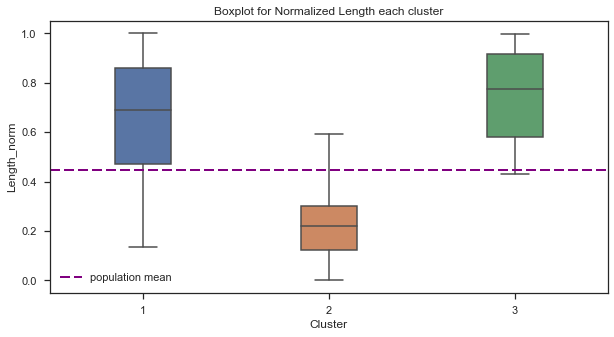

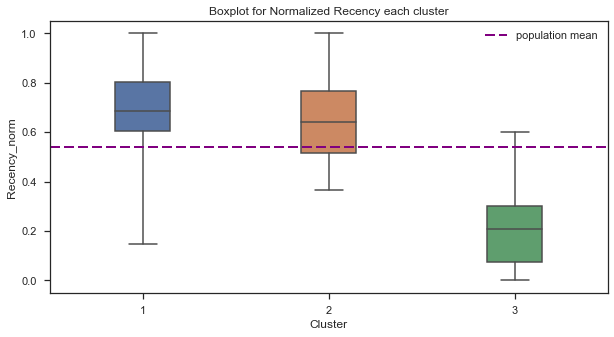

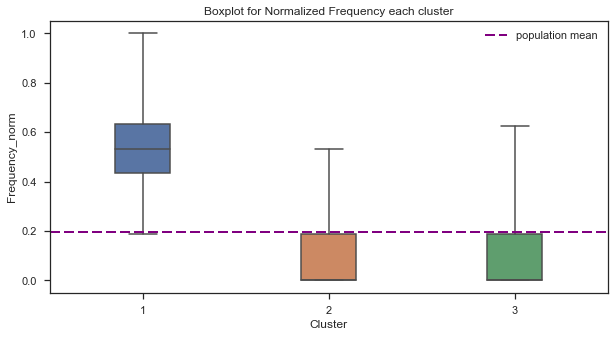

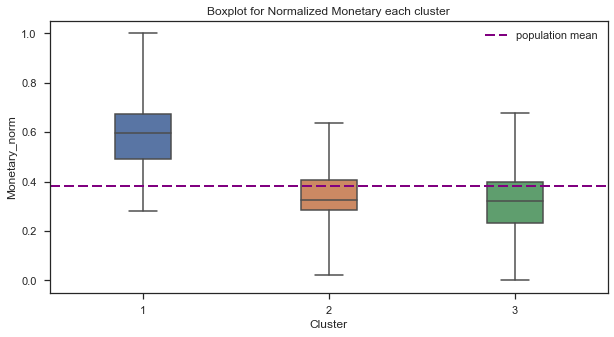

In [36]:
#Boxplot for Normalized data
fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Length_norm", data=df_lrfm_all, width=0.3, whis=10)
plt.title('Boxplot for Normalized Length each cluster') 
L_norm_mean = df_lrfm_all["Length_norm"].mean()
plt.plot([-0.5, 2.5], [L_norm_mean, L_norm_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.legend()
plt.savefig('Grafik/Cluster_is_3-L_boxplot_norm.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Recency_norm", data=df_lrfm_all, width=0.3, whis=10)
plt.title('Boxplot for Normalized Recency each cluster') 
R_norm_mean = df_lrfm_all["Recency_norm"].mean()
plt.plot([-0.5, 2.5], [R_norm_mean, R_norm_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.legend()
plt.savefig('Grafik/Cluster_is_3-R_boxplot_norm.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Frequency_norm", data=df_lrfm_all, width=0.3, whis=10)
plt.title('Boxplot for Normalized Frequency each cluster') 
F_norm_mean = df_lrfm_all["Frequency_norm"].mean()
plt.plot([-0.5, 2.5], [F_norm_mean, F_norm_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.legend()
plt.savefig('Grafik/Cluster_is_3-F_boxplot_norm.png', format='png', dpi=300)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = sns.boxplot(x="Cluster", y="Monetary_norm", data=df_lrfm_all, width=0.3, whis=10)
plt.title('Boxplot for Normalized Monetary each cluster') 
M_norm_mean = df_lrfm_all["Monetary_norm"].mean()
plt.plot([-0.5, 2.5], [M_norm_mean, M_norm_mean], 'k-', lw=2, dashes=[5, 2], color='purple', label="population mean")
plt.legend()
plt.savefig('Grafik/Cluster_is_3-M_boxplot_norm.png', format='png', dpi=300)
plt.show()

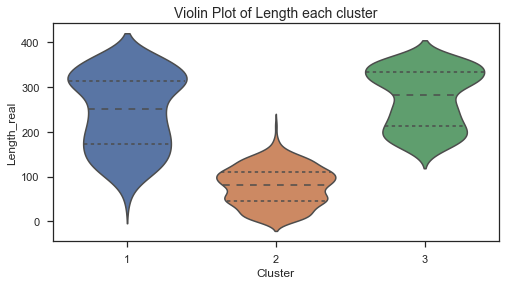

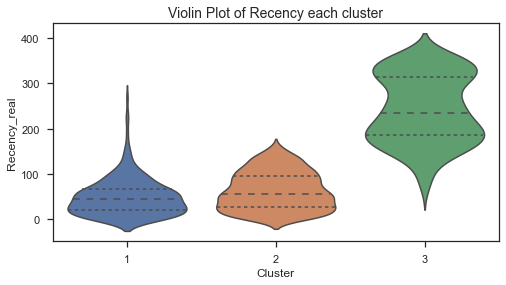

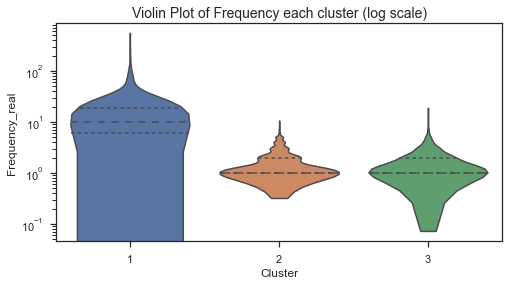

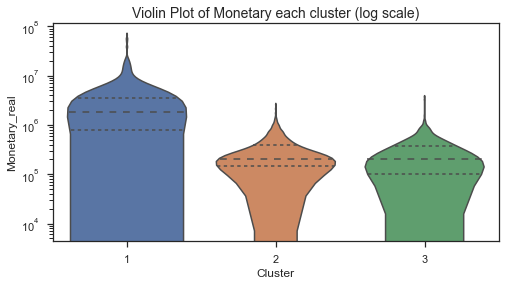

<Figure size 576x396 with 0 Axes>

In [37]:
#Violin Plot
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Length_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Length each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Recency_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Recency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Frequency_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.yscale("log")
plt.title('Violin Plot of Frequency each cluster (log scale)', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Monetary_real', data=df_lrfm_all, scale='width', inner='quartile')
plt.yscale("log")
plt.title('Violin Plot of Monetary each cluster (log scale)', fontsize=14)
plt.show()

plt.savefig('Grafik/Cluster_is_3-Violin.png', format='png', dpi=300)

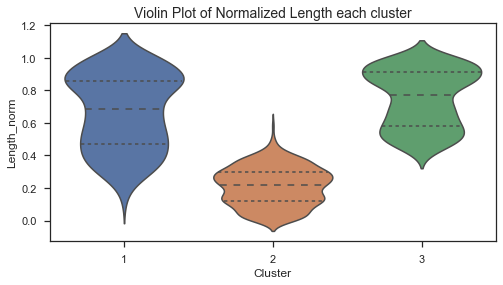

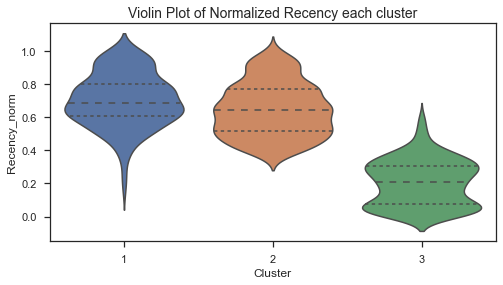

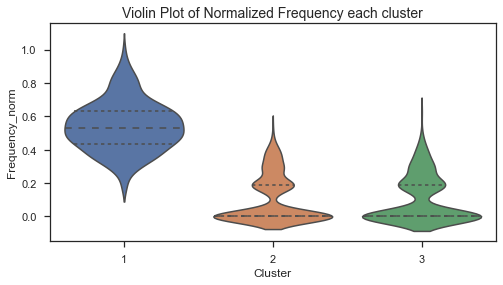

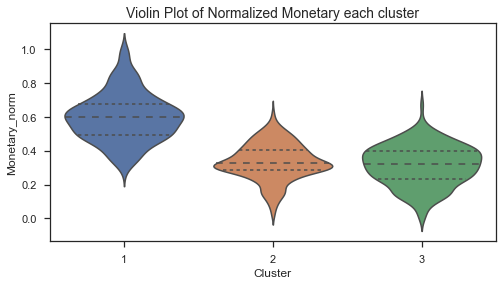

<Figure size 576x396 with 0 Axes>

In [38]:
#Violin Plot
plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Length_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Length each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Recency_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Recency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Frequency_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Frequency each cluster', fontsize=14)
plt.show()

plt.figure(figsize=(8,4))
sns.violinplot(x='Cluster', y='Monetary_norm', data=df_lrfm_all, scale='width', inner='quartile')
plt.title('Violin Plot of Normalized Monetary each cluster', fontsize=14)
plt.show()

plt.savefig('Grafik/Cluster_is_3-Violin_norm.png', format='png', dpi=300)

# Cluster Analysis

In [39]:
cluster_char = df_cluster_fix.reset_index().groupby(['Cluster']).describe()
cluster_char.transpose().to_csv("Hasil/Data_TA Cluster_characteristics.csv")
cluster_char

Length                                                             \
         count        mean        std    min     25%    50%    75%    max   
Cluster                                                                     
1        264.0  244.128788  83.933335   51.0  172.75  252.0  314.0  365.0   
2        691.0   79.289436  42.781279    2.0   46.00   82.0  111.0  217.0   
3        341.0  274.686217  64.704701  159.0  213.00  283.0  334.0  364.0   

        Recency              ... Frequency        Monetary                \
          count        mean  ...       75%    max    count          mean   
Cluster                      ...                                           
1         264.0   49.435606  ...      19.0  522.0    264.0  4.457373e+06   
2         691.0   63.264834  ...       2.0   10.0    691.0  3.155773e+05   
3         341.0  242.747801  ...       2.0   18.0    341.0  2.892446e+05   

                                                                             
                  std       min       25%        50%        75%         max  
Cluster                                                                      
1        8.849961e+06  148500.0  779750.0  1840900.0  3518600.0  66570810.0  
2        2.958202e+05   22000.0  149575.0   207900.0   384420.0   2574980.0  
3        3.391624e+05   18900.0  100000.0   200000.0   369700.0   3716000.0  

[3 rows x 32 columns]

In [40]:
df_cluster_fix.groupby(['Cluster']).agg('mean').round(3)

,Length,Recency,Frequency,Monetary
Cluster,,,,
1,244.129,49.436,21.598,4457373.178
2,79.289,63.265,1.790,315577.312
3,274.686,242.748,1.815,289244.604


In [41]:
#mean from all dataframe
df_lrfm_all.mean(axis=0).round(3)

Length_real           164.280
Recency_real          107.673
Frequency_real          5.832
Monetary_real     1152347.879
Cluster                 2.059
Length_norm             0.447
Recency_norm            0.541
Frequency_norm          0.195
Monetary_norm           0.383
dtype: float64

## Menghitung CLV

In [42]:
#Nilai bobot didapatkan dari file excel
AHP = {
    'Length' : 0.052,
    'Recency' : 0.099,
    'Frequency' : 0.362,
    'Monetary' : 0.486}

count    1296.000000
mean        0.333619
std         0.168424
min         0.055981
25%         0.208853
50%         0.289932
75%         0.433907
max         0.974343
Name: CLV, dtype: float64

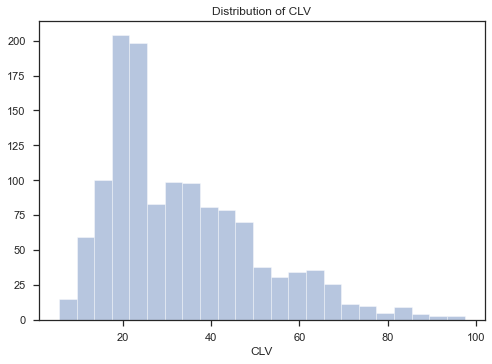

In [43]:
df_lrfm_all['CLV'] = (df_lrfm_all['Length_norm']*AHP['Length'] + df_lrfm_all['Recency_norm']*AHP['Recency'] + df_lrfm_all['Frequency_norm']*AHP['Frequency'] + df_lrfm_all['Monetary_norm']*AHP['Monetary'])
display(df_lrfm_all['CLV'].describe())

#Agar angka lebih cantik dan mudah dibaca, kita kalikan 1000
df_lrfm_all['CLV'] = df_lrfm_all['CLV']*100
plt.title('Distribution of CLV')
sns.distplot(df_lrfm_all['CLV'], kde=False)
plt.show()

In [44]:
df_lrfm_all.head(7)

,Length_real,Recency_real,Frequency_real,Monetary_real,Cluster,Length_norm,Recency_norm,Frequency_norm,Monetary_norm,CLV
telp,,,,,,,,,,
628111699469,66,66,1,165500.0,2,0.176309,0.605945,0.000000,0.296967,21.348267
628112501890,361,344,5,485000.0,3,0.988981,0.029402,0.398087,0.434146,40.944033
628113002154,361,103,3,612600.0,3,0.988981,0.493943,0.285844,0.463192,42.891425
628113020777,202,4,3,575000.0,1,0.550964,0.944687,0.285844,0.455340,44.694496
62811304876,329,27,16,897300.0,1,0.900826,0.767896,0.607727,0.510115,59.077782
62811308747,85,85,1,164000.0,2,0.228650,0.545349,0.000000,0.295780,20.962838
62811309692,330,7,116,18726912.0,1,0.903581,0.908968,0.860289,0.862475,86.756142


## Rank CLV

In [45]:
df_lrfm_all.groupby(['Cluster']).agg('mean').sort_values(by=['CLV'], ascending=False)

,Length_real,Recency_real,Frequency_real,Monetary_real,Length_norm,Recency_norm,Frequency_norm,Monetary_norm,CLV
Cluster,,,,,,,,,
1,244.128788,49.435606,21.598485,4.457373e+06,0.667021,0.701948,0.542074,0.598189,59.112849
2,79.289436,63.264834,1.790159,3.155773e+05,0.212919,0.645764,0.105698,0.335192,27.616850
3,274.686217,242.747801,1.815249,2.892446e+05,0.751202,0.204703,0.106810,0.314156,25.067297


In [46]:
def clv_values(df):
    clv_cluster = df.groupby(['Cluster']).agg({
        'Length_real': ['min', 'max', 'mean'],
        'Recency_real': ['min', 'max', 'mean'],
        'Frequency_real': ['min', 'max', 'mean'],
        'Monetary_real': ['min', 'max', 'mean'],
        'CLV' : ['min', 'max', 'mean', 'median']
    }).round(0)
    
    return clv_cluster

In [47]:
clv_values(df_lrfm_all).sort_values(by=[('CLV','mean')], ascending=False)

Length_real             Recency_real             Frequency_real       \
                min  max   mean          min  max   mean            min  max   
Cluster                                                                        
1                51  365  244.0            1  269   49.0              2  522   
2                 2  217   79.0            1  155   63.0              1   10   
3               159  364  275.0           68  364  243.0              1   18   

              Monetary_real                          CLV                     
         mean           min         max       mean   min   max  mean median  
Cluster                                                                      
1        22.0      148500.0  66570810.0  4457373.0  36.0  97.0  59.0   58.0  
2         2.0       22000.0   2574980.0   315577.0   8.0  59.0  28.0   24.0  
3         2.0       18900.0   3716000.0   289245.0   6.0  62.0  25.0   23.0

# Market Basket Analysis

In [48]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

## Join Dataframe

In [49]:
df_basket_all = pd.merge(df_clean, df_cluster_fix, on='telp', how='left')
df_basket_all = df_basket_all[['delivery_date', 'no_order', 'name', 'telp', 'produk', 'qty', 'Cluster']].copy()
df_basket_all.to_csv("Hasil/Data_TA Clustered_Transaksi.csv")

#drop NA from frequency outlier
df_basket_all.dropna(subset=['Cluster'], inplace=True)

print("Dataset dimension : " + str(df_basket_all.shape))
print('Jumlah Customer : ' + str(len(pd.unique(df_basket_all['telp']))))
print('Jumlah Transaksi : ' + str(len(pd.unique(df_basket_all['no_order']))))

#clean the product names
df_basket_all['produk'] = df_basket_all['produk'].str.strip()
df_basket_all['no_order'] = df_basket_all['no_order'].astype('str')

Dataset dimension : (22083, 7)
Jumlah Customer : 1296
Jumlah Transaksi : 7558


In [50]:
#one hot encode the basket
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

#create FP-Growth MBA for every cluster
def createMBA(basket_data, min_sup) :
    totalTransactions = len(basket_data.index)
    totalCustomers = len(pd.unique(basket_data['telp']))
    # minTransaction = totalTransactions*0.005
    # min_support_calc = minTransaction/totalTransactions

    print('Jumlah Pelanggan = ', totalCustomers)
    print('Jumlah Transaksi yang dianalisis = ', totalTransactions)
    print('Nilai Support Minimum = ', round(min_sup*100, 4), '%')

    basket = basket_data.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
    basket_sets = basket.applymap(encode_units)
    basket_sets.dropna(inplace=True)
    basket_sets = basket_sets.astype(int)
    # display(basket_sets.head(5))

    #create frequent items sets with clculated minimum support
    frequent_itemsets = fpgrowth(basket_sets, min_support=min_sup, use_colnames=True)
    # display(frequent_itemsets.describe())

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
    rules.sort_values('support', ascending = False, inplace = True)

    createMBA.rules = rules
    
    return rules

#Apriori
from mlxtend.frequent_patterns import apriori

def aprioriMBA(basket_data, min_sup) :
    totalTransactions = len(basket_data.index)
    totalCustomers = len(pd.unique(basket_data['telp']))
    # minTransaction = totalTransactions*0.005
    # min_support_calc = minTransaction/totalTransactions

    print('Jumlah Pelanggan = ', totalCustomers)
    print('Jumlah Transaksi yang dianalisis = ', totalTransactions)
    print('Nilai Support Minimum = ', round(min_sup*100, 4), '%')

    basket = basket_data.groupby(['no_order', 'produk'])['qty'].sum().unstack().reset_index().fillna(0).set_index('no_order')
    basket_sets = basket.applymap(encode_units)
    basket_sets.dropna(inplace=True)
    basket_sets = basket_sets.astype(int)
    # display(basket_sets.head(5))

    #create frequent items sets with clculated minimum support
    frequent_itemsets = apriori(basket_sets, min_support=min_sup, use_colnames=True)
    # display(frequent_itemsets.describe())

    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0)
    rules.sort_values('support', ascending = False, inplace = True)

    aprioriMBA.rules = rules
    
    return rules

In [51]:
#MBA w/ Clustering minsup 1%
for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis for Cluster", i)
    basket_data = df_basket_all[lambda x: x['Cluster'] == i]

    createMBA(basket_data, 0.01)
    mean_suppport = createMBA.rules['support'].mean()
    print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))
    print('rerata support = ', mean_suppport)
    
    
    display(createMBA.rules.head(5))
    createMBA.rules.to_csv("Hasil/Data_TA FPGrowth(minsup0.01)_Cluster_%s.csv" % (i,), ';')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n")

Market Basket Analysis for Cluster 1
Jumlah Pelanggan =  264
Jumlah Transaksi yang dianalisis =  16773
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  14
rerata support =  0.014097579330239559


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.078841,0.072520,0.019842,0.251670,3.470370,0.014124,1.239401
13,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.072520,0.078841,0.019842,0.273608,3.470370,0.014124,1.268129
4,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.030378,0.041264,0.015277,0.502890,12.187062,0.014023,1.928620
5,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.041264,0.030378,0.015277,0.370213,12.187062,0.014023,1.539603
10,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.041264,0.030026,0.015101,0.365957,12.187881,0.013862,1.529824




Market Basket Analysis for Cluster 2
Jumlah Pelanggan =  691
Jumlah Transaksi yang dianalisis =  3863
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  6
rerata support =  0.010594947025264874


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.047270,0.046455,0.010595,0.224138,4.824864,0.008399,1.229014
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.046455,0.047270,0.010595,0.228070,4.824864,0.008399,1.234219
2,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR RRC SWEET ONS),0.052975,0.027710,0.010595,0.200000,7.217647,0.009127,1.215363
3,(BUAH PEAR RRC SWEET ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.027710,0.052975,0.010595,0.382353,7.217647,0.009127,1.533279
4,(PROMO (DORI FILLET 500GR)),(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),0.026080,0.024450,0.010595,0.406250,16.615625,0.009957,1.643032




Market Basket Analysis for Cluster 3
Jumlah Pelanggan =  341
Jumlah Transaksi yang dianalisis =  1447
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  50
rerata support =  0.019644588045234248


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
1,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
34,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.075929,0.061389,0.037157,0.489362,7.971445,0.032495,1.838113
35,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.061389,0.075929,0.037157,0.605263,7.971445,0.032495,2.340980
33,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.061389,0.075929,0.035541,0.578947,7.624860,0.030880,2.194669


In [52]:
#Apriori MBA w/ Clustering minsup 1%
for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis for Cluster", i)
    basket_data = df_basket_all[lambda x: x['Cluster'] == i]

    aprioriMBA(basket_data, 0.01)
    mean_suppport = aprioriMBA.rules['support'].mean()
    print('rules berhasil dibangkitkan = ', len(aprioriMBA.rules.index))
    print('rerata support = ', mean_suppport)
    
    display(aprioriMBA.rules.head(5))
    aprioriMBA.rules.to_csv("Hasil/Data_TA Apriori(minsup0.01)_Cluster_%s.csv" % (i,), ';')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n")

Market Basket Analysis for Cluster 1
Jumlah Pelanggan =  264
Jumlah Transaksi yang dianalisis =  16773
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  14
rerata support =  0.014097579330239559


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.078841,0.072520,0.019842,0.251670,3.470370,0.014124,1.239401
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.072520,0.078841,0.019842,0.273608,3.470370,0.014124,1.268129
6,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.030378,0.041264,0.015277,0.502890,12.187062,0.014023,1.928620
7,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.041264,0.030378,0.015277,0.370213,12.187062,0.014023,1.539603
2,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.041264,0.030026,0.015101,0.365957,12.187881,0.013862,1.529824




Market Basket Analysis for Cluster 2
Jumlah Pelanggan =  691
Jumlah Transaksi yang dianalisis =  3863
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  6
rerata support =  0.010594947025264874


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR RRC SWEET ONS),0.052975,0.027710,0.010595,0.200000,7.217647,0.009127,1.215363
1,(BUAH PEAR RRC SWEET ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.027710,0.052975,0.010595,0.382353,7.217647,0.009127,1.533279
2,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.047270,0.046455,0.010595,0.224138,4.824864,0.008399,1.229014
3,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.046455,0.047270,0.010595,0.228070,4.824864,0.008399,1.234219
4,(PROMO (DORI FILLET 500GR)),(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),0.026080,0.024450,0.010595,0.406250,16.615625,0.009957,1.643032




Market Basket Analysis for Cluster 3
Jumlah Pelanggan =  341
Jumlah Transaksi yang dianalisis =  1447
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  50
rerata support =  0.019644588045234248


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
16,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
17,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
20,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.075929,0.061389,0.037157,0.489362,7.971445,0.032495,1.838113
21,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.061389,0.075929,0.037157,0.605263,7.971445,0.032495,2.340980
10,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.075929,0.061389,0.035541,0.468085,7.624860,0.030880,1.764588


Market Basket Analysis for Cluster 1
Jumlah Pelanggan =  264
Jumlah Transaksi yang dianalisis =  16773
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  100


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.078841,0.072520,0.019842,0.251670,3.470370,0.014124,1.239401
45,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.072520,0.078841,0.019842,0.273608,3.470370,0.014124,1.268129
10,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.030378,0.041264,0.015277,0.502890,12.187062,0.014023,1.928620
11,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.041264,0.030378,0.015277,0.370213,12.187062,0.014023,1.539603
23,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.030026,0.041264,0.015101,0.502924,12.187881,0.013862,1.928751
22,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.041264,0.030026,0.015101,0.365957,12.187881,0.013862,1.529824
6,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA ORIGINAL 1L),0.041264,0.033011,0.014925,0.361702,10.956881,0.013563,1.514949
7,(JABMILK SUSU RASA ORIGINAL 1L),(JABMILK SUSU RASA COKLAT 1L),0.033011,0.041264,0.014925,0.452128,10.956881,0.013563,1.749925
18,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.030378,0.030026,0.012116,0.398844,13.283136,0.011204,1.613514
19,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.030026,0.030378,0.012116,0.403509,13.283136,0.011204,1.625544




Market Basket Analysis for Cluster 2
Jumlah Pelanggan =  691
Jumlah Transaksi yang dianalisis =  3863
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  46


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(BUAH PEAR RRC SWEET ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.027710,0.052975,0.010595,0.382353,7.217647,0.009127,1.533279
38,(PROMO (DORI FILLET 500GR)),(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),0.026080,0.024450,0.010595,0.406250,16.615625,0.009957,1.643032
14,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR RRC SWEET ONS),0.052975,0.027710,0.010595,0.200000,7.217647,0.009127,1.215363
39,(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),(PROMO (DORI FILLET 500GR)),0.024450,0.026080,0.010595,0.433333,16.615625,0.009957,1.718683
8,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.047270,0.046455,0.010595,0.224138,4.824864,0.008399,1.229014
9,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.046455,0.047270,0.010595,0.228070,4.824864,0.008399,1.234219
12,(DAGING SAPI BUNTUT SPECIAL 250GR),(DAGING SAPI IGA SPECIAL 250GR),0.022820,0.030155,0.008965,0.392857,13.027992,0.008277,1.597392
17,(JSM (BUAH APEL FUJI ONS)),(PROMO (DORI FILLET 500GR)),0.022820,0.026080,0.008965,0.392857,15.063616,0.008370,1.604104
16,(PROMO (DORI FILLET 500GR)),(JSM (BUAH APEL FUJI ONS)),0.026080,0.022820,0.008965,0.343750,15.063616,0.008370,1.489036
31,(BUAH PEAR YALIE ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.018745,0.052975,0.008965,0.478261,9.028094,0.007972,1.815132




Market Basket Analysis for Cluster 3
Jumlah Pelanggan =  341
Jumlah Transaksi yang dianalisis =  1447
Nilai Support Minimum =  0.5 %
rules berhasil dibangkitkan =  204


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
12,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.075929,0.075929,0.045234,0.595745,7.846084,0.039469,2.285860
66,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.075929,0.061389,0.037157,0.489362,7.971445,0.032495,1.838113
67,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.061389,0.075929,0.037157,0.605263,7.971445,0.032495,2.340980
64,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.075929,0.061389,0.035541,0.468085,7.624860,0.030880,1.764588
65,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.061389,0.075929,0.035541,0.578947,7.624860,0.030880,2.194669
71,(JABMILK SUSU RASA STROBERI 1L),"(JABMILK SUSU RASA COKLAT 1L, JABMILK SUSU RAS...",0.075929,0.035541,0.029079,0.382979,10.775629,0.026381,1.563088
73,(JABMILK SUSU RASA MELON 1L),"(JABMILK SUSU RASA STROBERI 1L, JABMILK SUSU R...",0.061389,0.045234,0.029079,0.473684,10.471805,0.026302,1.814055
72,(JABMILK SUSU RASA COKLAT 1L),"(JABMILK SUSU RASA STROBERI 1L, JABMILK SUSU R...",0.075929,0.037157,0.029079,0.382979,10.307123,0.026258,1.560470
70,"(JABMILK SUSU RASA COKLAT 1L, JABMILK SUSU RAS...",(JABMILK SUSU RASA STROBERI 1L),0.035541,0.075929,0.029079,0.818182,10.775629,0.026381,5.082391


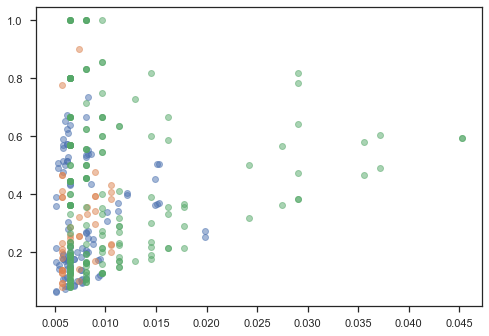

In [53]:
#MBA w/ Clustering minsup 0.5%
for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis for Cluster", i)
    basket_data = df_basket_all[lambda x: x['Cluster'] == i]

    createMBA(basket_data, 0.005)
    print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

    display(createMBA.rules.head(10))

    plt.scatter(createMBA.rules['support'], createMBA.rules['confidence'], alpha=0.5)
    # plt.xlabel('support')
    # plt.ylabel('confidence')
    # plt.title('Support vs Confidence')
    # plt.show()

    createMBA.rules.to_csv("Hasil/Data_TA FPGrowth (minsup0.005)_Cluster_%s.csv" % (i,), ';')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n")

# Experiment

In [54]:
#MBA w/o Clustering
createMBA(df_basket_all, 0.01)
print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

display(createMBA.rules.head(10))
createMBA.rules.to_csv("Hasil/Data_EXP FPGrowth_NO_Cluster_%s.csv", ';')
# rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_FPGrowth_Cluster_All.csv", 'a', newline='')
print("\n \n")

Jumlah Pelanggan =  1296
Jumlah Transaksi yang dianalisis =  22083
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  12


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.073995,0.067763,0.017902,0.241935,3.570324,0.012888,1.229760
11,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.067763,0.073995,0.017902,0.264188,3.570324,0.012888,1.258480
0,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA COKLAT 1L),0.031428,0.039783,0.016178,0.514768,12.939550,0.014928,1.978883
1,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA STROBERI 1L),0.039783,0.031428,0.016178,0.406667,12.939550,0.014928,1.632424
8,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA MELON 1L),0.039783,0.029704,0.015250,0.383333,12.904985,0.014068,1.573453
9,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA COKLAT 1L),0.029704,0.039783,0.015250,0.513393,12.904985,0.014068,1.973291
4,(JABMILK SUSU RASA COKLAT 1L),(JABMILK SUSU RASA ORIGINAL 1L),0.039783,0.030367,0.014056,0.353333,11.635313,0.012848,1.499432
5,(JABMILK SUSU RASA ORIGINAL 1L),(JABMILK SUSU RASA COKLAT 1L),0.030367,0.039783,0.014056,0.462882,11.635313,0.012848,1.787722
6,(JABMILK SUSU RASA STROBERI 1L),(JABMILK SUSU RASA MELON 1L),0.031428,0.029704,0.012863,0.409283,13.778575,0.011929,1.642572
7,(JABMILK SUSU RASA MELON 1L),(JABMILK SUSU RASA STROBERI 1L),0.029704,0.031428,0.012863,0.433036,13.778575,0.011929,1.708347


In [55]:
#MBA w/o Jabmilk
jabmilk = ['JABMILK', 'JAB MILK']
df_basket_nonjabmilk = df_basket_all[~df_basket_all['produk'].str.contains('|'.join(jabmilk))]

for i in range(1, K_fix+1) :
    #slice data
    print("Market Basket Analysis (Without Jabmilk) for Cluster", i)
    basket_data = df_basket_nonjabmilk[lambda x: x['Cluster'] == i]

    createMBA(basket_data, 0.01)
    print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))

    display(createMBA.rules.head(10))
    createMBA.rules.to_csv("Hasil/Data_EXP FPGrowth_nonjabmilk_Cluster_%s.csv" % (i,), ';')
    # rules[(rules['lift'] >= 0.2) & (rules['confidence'] >= 0.1)].sort_values(by=['confidence', 'lift'], ascending=False).to_csv("Data/Ternakmart_Results_nonjabmilk_FPGrowth_Cluster_%s.csv" % (i,), 'a', newline='')
    print("\n \n")

Market Basket Analysis (Without Jabmilk) for Cluster 1
Jumlah Pelanggan =  264
Jumlah Transaksi yang dianalisis =  15823
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  2


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.080697,0.074227,0.020309,0.251670,3.390542,0.014319,1.237119
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.074227,0.080697,0.020309,0.273608,3.390542,0.014319,1.265573



 

Market Basket Analysis (Without Jabmilk) for Cluster 2
Jumlah Pelanggan =  688
Jumlah Transaksi yang dianalisis =  3770
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  6


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.047658,0.046836,0.010682,0.224138,4.785541,0.008450,1.228522
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.046836,0.047658,0.010682,0.228070,4.785541,0.008450,1.233716
2,(BUAH APEL FUJI PREMIUM RRC ONS),(BUAH PEAR RRC SWEET ONS),0.053410,0.027938,0.010682,0.200000,7.158824,0.009190,1.215078
3,(BUAH PEAR RRC SWEET ONS),(BUAH APEL FUJI PREMIUM RRC ONS),0.027938,0.053410,0.010682,0.382353,7.158824,0.009190,1.532574
4,(PROMO (DORI FILLET 500GR)),(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),0.026294,0.024651,0.010682,0.406250,16.480208,0.010034,1.642693
5,(JSM (BELI 1 GRATIS 1SOSIS SAPI ABBYS 200GR)),(PROMO (DORI FILLET 500GR)),0.024651,0.026294,0.010682,0.433333,16.480208,0.010034,1.718304



 

Market Basket Analysis (Without Jabmilk) for Cluster 3
Jumlah Pelanggan =  330
Jumlah Transaksi yang dianalisis =  1266
Nilai Support Minimum =  1.0 %
rules berhasil dibangkitkan =  14


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
12,(TELUR AYAM NEGERI KG),(DAGING AYAM FILLET DADA KG),0.053726,0.088388,0.019064,0.354839,4.014548,0.014315,1.412998
13,(DAGING AYAM FILLET DADA KG),(TELUR AYAM NEGERI KG),0.088388,0.053726,0.019064,0.215686,4.014548,0.014315,1.206499
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.088388,0.071057,0.015598,0.176471,2.483501,0.009317,1.128002
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.071057,0.088388,0.015598,0.219512,2.483501,0.009317,1.168003
4,(DAGING AYAM PAHA BAWAH KG),(DAGING AYAM CEKER KG),0.041594,0.053726,0.012132,0.291667,5.428763,0.009897,1.335916
5,(DAGING AYAM CEKER KG),(DAGING AYAM PAHA BAWAH KG),0.053726,0.041594,0.012132,0.225806,5.428763,0.009897,1.237940
6,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM PAHA BAWAH KG),0.071057,0.041594,0.012132,0.170732,4.104675,0.009176,1.155724
7,(DAGING AYAM PAHA BAWAH KG),(DAGING AYAM FILLET PAHA KG),0.041594,0.071057,0.012132,0.291667,4.104675,0.009176,1.311449
8,(DAGING AYAM SAYAP KG),(DAGING AYAM FILLET PAHA KG),0.045061,0.071057,0.012132,0.269231,3.788931,0.008930,1.271185
9,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM SAYAP KG),0.071057,0.045061,0.012132,0.170732,3.788931,0.008930,1.151544


In [56]:
#MBA w/o Clustering w/o Jabmilk
createMBA(df_basket_nonjabmilk, 0.007)
print('rules berhasil dibangkitkan = ', len(createMBA.rules.index))
createMBA.rules.to_csv("Hasil/Data_EXP FPGrowth_nonjabmilk_NO_Cluster_%s.csv", ';')

display(createMBA.rules.head(10))

Jumlah Pelanggan =  1282
Jumlah Transaksi yang dianalisis =  20859
Nilai Support Minimum =  0.7 %
rules berhasil dibangkitkan =  14


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DAGING AYAM FILLET DADA KG),(DAGING AYAM FILLET PAHA KG),0.075836,0.069448,0.018347,0.241935,3.483682,0.013081,1.227536
1,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM FILLET DADA KG),0.069448,0.075836,0.018347,0.264188,3.483682,0.013081,1.255978
10,(TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR)),(LAHAP WANITA BERAS PREMIUM 5KG),0.078962,0.047431,0.007883,0.099828,2.104681,0.004137,1.058207
11,(LAHAP WANITA BERAS PREMIUM 5KG),(TELUR AYAM NEGERI 1PACK (ISI 15 BUTIR)),0.047431,0.078962,0.007883,0.166189,2.104681,0.004137,1.104613
2,(DAGING AYAM FILLET DADA KG),(JAB FROZEN YOGURT),0.075836,0.047160,0.007475,0.098566,2.090060,0.003898,1.057028
3,(JAB FROZEN YOGURT),(DAGING AYAM FILLET DADA KG),0.047160,0.075836,0.007475,0.158501,2.090060,0.003898,1.098236
4,(DAGING AYAM SAYAP KG),(DAGING AYAM FILLET PAHA KG),0.033977,0.069448,0.007339,0.216000,3.110231,0.004979,1.186928
5,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM SAYAP KG),0.069448,0.033977,0.007339,0.105675,3.110231,0.004979,1.080171
8,(DAGING AYAM PAHA BAWAH KG),(DAGING AYAM FILLET PAHA KG),0.034384,0.069448,0.007203,0.209486,3.016437,0.004815,1.177148
9,(DAGING AYAM FILLET PAHA KG),(DAGING AYAM PAHA BAWAH KG),0.069448,0.034384,0.007203,0.103718,3.016437,0.004815,1.077357
